# Electric Circuit in Matrix Representation

Directed Acyclic Graph:
$$(V,E)$$

Incidence matrix:
\begin{equation}
N_{v,e} = 
\begin{cases}
  +1 &(v \rightarrow u) = e \in E\\
  -1 &(u \rightarrow v) = e \in E\\
  0  &\text{otherwise}
\end{cases}
\end{equation}

Kirchoff’s Law for Nodal Current (flow-in) $c^{in}$ and Branch Current $i$:

\begin{align*}
c^{in}_v &= \sum_{(v\rightarrow u)\in E}{i_{(v\rightarrow u)}} - \sum_{(u\rightarrow v)\in E}{i_{(u\rightarrow v)}}
\\
&= \sum_{e\in E}N_{v,e}{i_e}
\\
\Leftrightarrow c^{in} &= N i 
\end{align*}

Nodal Voltage $p$ and Branch Voltage $q$:
\begin{align*}
q_{(v\rightarrow u)} &= p_v - p_u
\\
\Leftrightarrow q_e &= \sum_v N_{v,e} p_v
\\
\Leftrightarrow q &= N^T p
\end{align*}

Branch Voltage q and Branch current i, Branch Resistence r:

\begin{align*}
q_e &= r_e i_e
\\
q &= \text{diag}(r)i
\end{align*}

Therefore, by defining $A = N\text{diag}(r)^{-1}N^T$ (nodal conductance matrix), we get:

\begin{align*}
c^{in} &= Ni
\\
&= N\text{diag}(r)^{-1}q
\\
&= N\text{diag}(r)^{-1}N^T p
\\
&= A p 
\end{align*}

# Import Packages

In [1]:
import numpy as np
import scipy.linalg
import scipy.sparse.linalg
from scipy.sparse import csc_matrix, dia_matrix,eye
import matplotlib as mpl
from matplotlib import cm
from matplotlib import pyplot as plt
import time

# Define Circuit

In [2]:
def get_incidence_matrix(n):

    # vertex_i is (i//n, i%n)

    # define horizontal edges
    tail_horizontal_vert = np.arange(n*n)[np.arange(n*n)%n != n-1]
    tail_horizontal_edge = np.arange(n*(n-1))
    head_horizontal_vert = np.arange(n*n)[np.arange(n*n)%n != 0]
    head_horizontal_edge = np.arange(n*(n-1))

    # define vertical edges
    tail_vertical_vert = np.arange(n*(n-1))
    tail_vertical_edge = np.arange(n*(n-1)) + n*n - n
    head_vertical_vert = np.arange(n*(n-1)) + n
    head_vertical_edge = np.arange(n*(n-1)) + n*n - n

    row = np.concatenate([
        tail_horizontal_vert,
        tail_vertical_vert,
        head_horizontal_vert,
        head_vertical_vert
    ])
    col = np.concatenate([
        tail_horizontal_edge, 
        tail_vertical_edge,
        head_horizontal_edge,
        head_vertical_edge
    ])
    data = np.concatenate([np.ones([2*n*n - 2*n]), - np.ones([2*n*n - 2*n])])
    N = csc_matrix((data, (row, col)), shape=(n*n, 2*n*n - 2*n))
    
    return N

In [3]:
def get_preconditioner_matrix(n):
    
    # define horizontal edges
    tail_horizontal_vert = np.arange(n*n)[np.arange(n*n)%n != n-1]
    tail_horizontal_edge = np.arange(n*(n-1))
    head_horizontal_vert = np.arange(n*n)[np.arange(n*n)%n != 0]
    head_horizontal_edge = np.arange(n*(n-1))

    # define vertical edges
    tail_vertical_vert = np.arange(n-1)*n + n//2
    tail_vertical_edge = np.arange(n-1)*n + n//2 + n*(n-1)
    head_vertical_vert = np.arange(n-1)*n + n//2 + n
    head_vertical_edge = np.arange(n-1)*n + n//2 + n*(n-1)

    row = np.concatenate([
        tail_horizontal_vert,
        tail_vertical_vert,
        head_horizontal_vert,
        head_vertical_vert
    ])
    col = np.concatenate([
        tail_horizontal_edge, 
        tail_vertical_edge,
        head_horizontal_edge,
        head_vertical_edge
    ])
    data = np.concatenate([np.ones([2*n*n - 2*n]), - np.ones([2*(n-1)])])
    N = csc_matrix((data, (row, col)), shape=(n*n, 2*n*n - 2*n))
    
    return N

In [4]:
def draw_box(x_tail, y_tail, x_head, y_head):
    width  = (np.abs(x_head - x_tail) + 1) / 4
    height = (np.abs(y_head - y_tail) + 1) / 4
    x = (x_tail + x_head) / 2 - width / 2
    y = (y_tail + y_head) / 2 - height / 2
    box = plt.Rectangle((x,y), width, height, fill=True, facecolor='white', edgecolor='black')
    plt.gca().add_patch(box)

def draw_text(x_tail, y_tail, x_head, y_head, text):
    shift_x = np.abs(y_head - y_tail) / 8
    shift_y = np.abs(x_head - x_tail) / 8
    x = (x_tail + x_head) / 2 + shift_x
    y = (y_tail + y_head) / 2 + shift_y
    plt.text(x, y, text, fontsize=8)
    
def draw_edge(v_idx_tail, v_idx_head, n, style, text=None, color='black'):
    x_tail = v_idx_tail%n
    y_tail = v_idx_tail//n
    x_head = v_idx_head%n
    y_head = v_idx_head//n
    dx = (x_head - x_tail)
    dy = (y_head - y_tail)
    
    if style=='direction':
        plt.arrow(x_tail + dx*0.1, y_tail + dy*0.1, dx*0.8, dy*0.8, head_width=0.1, color=color, length_includes_head=True)
    elif style=='circuit':
        plt.arrow(x_tail, y_tail, dx/4, dy/4, head_width=0, color='black', length_includes_head=True)
        plt.arrow(x_tail+3*dx/4, y_tail+3*dy/4, dx/4, dy/4, head_width=0, color='black', length_includes_head=True)
        draw_box(x_tail, y_tail, x_head, y_head)
        if text is not None:
            draw_text(x_tail, y_tail, x_head, y_head, text)
               
def draw_graph(N, n, style='direction', nodal_voltage=None, branch_current=None):
        
    #draw vertices
    #plt.scatter(np.arange(n*n)%n, np.arange(n*n)//n, s = 20, color='black')
    ax = plt.gca()
    if nodal_voltage is None:
        ax.scatter(np.arange(n*n)%n, np.arange(n*n)//n, s = 20, color='black')
        if style=='circuit':
            for i in range(n*n):
                ax.annotate(str(i+1), (i%n, i//n))
    else:
        c =  nodal_voltage
        sc = plt.scatter(np.arange(n*n)%n, np.arange(n*n)//n, s = 100, c=c)
        cbar1 = plt.colorbar(sc)
        cbar1.ax.set_ylabel('Nodal Voltage')
        
    #draw edges
    n_edge = N.shape[1]
    
    if branch_current is not None:
        rel_current = (branch_current - branch_current.min())/ (branch_current.max() - branch_current.min())
        cmap = plt.get_cmap('binary')
        null_plt = plt.scatter([],[], c=[], cmap=cmap)
        null_plt.set_clim(0, branch_current.max())
        cbar2 = plt.colorbar(null_plt)
        cbar2.ax.set_ylabel('Branch Current')
        
    for e_idx in range(n_edge):
        
        col0 = N.getcol(e_idx)
        v_idx = col0.nonzero()[0]
        
        if branch_current is None: 
            text = str(e_idx+1) 
            color = 'black'
        else:
            text = None
            color = cmap(rel_current[e_idx])
            
        if N[v_idx[0], e_idx] ==1:
            # draw edge from v_idx[0] to v_idx[1]
            draw_edge(v_idx[0], v_idx[1], n, style, text, color)
        elif N[v_idx[1], e_idx]==1:
            # draw edge from v_idx[1] to v_idx[0]
            draw_edge(v_idx[1], v_idx[0], n, style, text, color)
            
    # config plot
    plt.xlim([-0.5, n-0.5])
    plt.ylim([-0.5, n-0.5])

    plt.axis('off')

In [5]:
n = 3
N = get_incidence_matrix(n)
G = eye(2*n*n - 2*n); inv_G = eye(2*n*n - 2*n)
A = N@G@N.T

In [6]:
Arr = np.int8(N.toarray())
for arr in Arr:
    print(("{: d} &"*(2*3*3 - 2*3 - 1) + "{: d}\\\\").format(*tuple(arr)))

 1 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
-1 & 1 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
 0 &-1 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
 0 & 0 & 1 & 0 & 0 & 0 &-1 & 0 & 0 & 1 & 0 & 0\\
 0 & 0 &-1 & 1 & 0 & 0 & 0 &-1 & 0 & 0 & 1 & 0\\
 0 & 0 & 0 &-1 & 0 & 0 & 0 & 0 &-1 & 0 & 0 & 1\\
 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 &-1 & 0 & 0\\
 0 & 0 & 0 & 0 &-1 & 1 & 0 & 0 & 0 & 0 &-1 & 0\\
 0 & 0 & 0 & 0 & 0 &-1 & 0 & 0 & 0 & 0 & 0 &-1\\


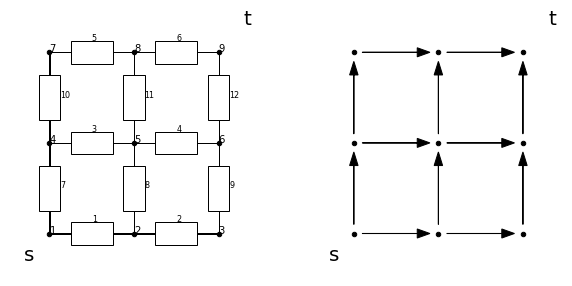

In [7]:
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
draw_graph(N, n, 'circuit')
plt.text(-0.3,-0.3,'s',fontsize=20)
plt.text(n-0.7,n-0.7,'t',fontsize=20)

plt.subplot(1,2,2)
draw_graph(N, n, 'direction')
plt.text(-0.3,-0.3,'s',fontsize=20)
plt.text(n-0.7,n-0.7,'t',fontsize=20)

plt.savefig('circuit.eps')

In [8]:
# set parameters
n = 10

In [9]:
N = get_incidence_matrix(n)
G = eye(2*n*n - 2*n); inv_G = eye(2*n*n - 2*n)
A = N@G@N.T

# Solve Linear System

Because the incidence matrix of a fully connected matrix has rank $(\text{#nodes}-1)$, we know that

$$\text{rank}(A) = \min\{\text{rank}(N), \text{rank}(\text{diag}(r))\} = \min\{\text{#nodes}-1, \text{#branches}\} = \text{#nodes}-1$$

Thus, by setting the voltage of source node zero, namely, $p_0 = 0$ we can obtain the voltage of the sink node.
(It is easy to see that $p = \mathbb{1} := (1,1,...,1)^T$ is one of the solution to $Ap=c^{in}$)

In [10]:
SLU = scipy.sparse.linalg.splu(A)
len(SLU.U.nonzero()[0])

763

In [11]:
c = np.array(np.zeros([n*n,1]))
c[0,0]      =  1
c[n*n-1, 0] = -1

In [12]:
x = scipy.sparse.linalg.cg(A, c)[0]
p = x - x[n*n-1]
q = N.T@p
i = inv_G@q

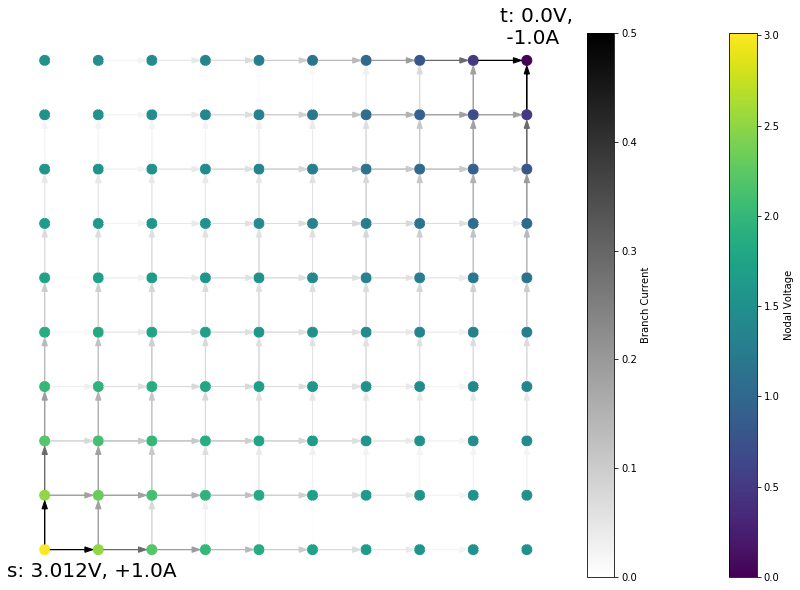

In [13]:
plt.figure(figsize=[15,10])
draw_graph(N, n, 'direction', nodal_voltage=p, branch_current=i)
plt.text(-0.7,-0.5,'s: {:{prec}}V, +1.0A'.format(p[0], prec=3.4),fontsize=20)
plt.text(n-1.5,n-0.7,'t: 0.0V,\n -1.0A',fontsize=20)

plt.savefig('circuit2.eps')

# Measure the Performance

In [14]:
def runtime(func, get_val=False):
    start = time.time()
    val = func()
    end = time.time()
    if get_val:
        return end - start, val
    else:
        return end - start
    
def count_nonzero(LU):
    return len(LU.L.nonzero()[0]) + len(LU.U.nonzero()[0])

def measure_time(n, n_iter=3):
    
    avetime_sparse_lu = 0
    avetime_sparse_cg = 0
    avetime_sparse_cg_pre = 0
    avetime_dense_lu  = 0
    avefillin = 0
    
    for i in range(n_iter):
    
        N = get_incidence_matrix(n)
        G = eye(2*n*n - 2*n); inv_G = eye(2*n*n - 2*n)
        A = N@G@N.T
        N_pre = get_preconditioner_matrix(n)
        M = N_pre@N_pre.T
        A_dense = A.toarray() if n*n<20000 else np.nan
        c = np.array(np.zeros([n*n,1]))
        c[0,0]      =  1
        c[n*n-1, 0] = -1
        
        time, LU = runtime(lambda: scipy.sparse.linalg.splu(A), get_val=True)
        avefillin += count_nonzero(LU) / n_iter
        avetime_sparse_lu += time / n_iter
        avetime_sparse_cg += runtime(lambda: scipy.sparse.linalg.cg(A, c)) / n_iter
        avetime_sparse_cg_pre += runtime(lambda: scipy.sparse.linalg.cg(A, c,M=M)) / n_iter
        avetime_dense_lu  += runtime(lambda: scipy.linalg.lu(A_dense)) if n*n<20000 else np.nan / n_iter
        
    return [avetime_sparse_lu, avetime_sparse_cg, avetime_dense_lu, avetime_sparse_cg_pre, avefillin]

In [15]:
ns = np.int32(2**(2+np.arange(13)/2)) 
results = np.array([measure_time(n, 1) for n in ns])

Text(0, 0.5, 'runtime (sec)')

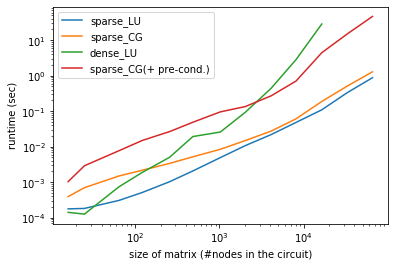

In [16]:
plt.plot(ns**2, results[:,:4])
plt.legend(['sparse_LU', 'sparse_CG', 'dense_LU', 'sparse_CG(+ pre-cond.)'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('size of matrix (#nodes in the circuit)')
plt.ylabel('runtime (sec)')
#plt.savefig('runtime.eps')

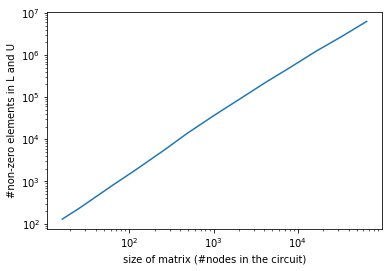

In [17]:
plt.plot(ns**2, results[:,4])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('size of matrix (#nodes in the circuit)')
plt.ylabel('#non-zero elements in L and U')
plt.savefig('fillin.eps')